Data: https://www.kaggle.com/datasets/nikhilroxtomar/person-segmentation?resource=download

In [1]:
import numpy as np
from matplotlib import colors, pyplot as plt

from tqdm.notebook import tqdm
from PIL import Image
from pathlib import Path
from typing import Iterable
from enum import Enum
from itertools import chain

import torch
from torchvision.transforms import v2
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR

In [2]:
NAMES_PATH = Path('.')/'segmentation'
IMAGES_PATH = Path('.')/'images'
MASKS_PATH = Path('.')/'masks'

RESCALE_SIZE = 224

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

MEAN = np.array([0.485, 0.456, 0.406])
STD = np.array([0.229, 0.224, 0.225])

In [3]:
class ImageDataset(Dataset):
    
    class MODE(Enum):
        TRAIN = 'train'
        VAL = 'val'
        TEST = 'test'
        
    transform_image = v2.Compose([
            v2.ToTensor(),
            v2.Normalize(MEAN, STD)
    ])
        
    def __init__(self, mode: MODE, names: Iterable[str], path_to_inputs: Path,  path_to_outputs: None|Path = None, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.mode = mode
        self.files = list()
        for name in names:
            try:
                x = next(path_to_inputs.rglob(name + '.*'))
                if self.mode == self.MODE.TEST:   
                    self.files.append((x,))
                else:
                    y = next(path_to_outputs.rglob(name + '.*'))
                    self.files.append((x, y))
            except StopIteration:
                continue
            
    def __len__(self) -> int:
        return len(self.files)  
    
    def __getitem__(self, index: int) -> tuple[torch.Tensor, torch.Tensor]|torch.Tensor:   
        if self.mode == self.MODE.TEST:
            image = self.files[index][0]
        else:
            image, mask = self.files[index]
            mask = self.load_sample(mask)
            mask = self._prepare_sample(mask)
            mask = torch.from_numpy(mask)
            
        image = self.load_sample(image)
        image = self._prepare_sample(image)
        image = np.array(image / 255, dtype='float32')
        image = self.transform_image(image) 
        if self.mode == self.MODE.TEST:
            return image
        else:
            return image, mask
        
    def load_sample(self, file: Path) -> Image.Image:
        image = Image.open(file)
        image.load()
        return image
    
    def _prepare_sample(self, image: Image.Image) -> np.ndarray:
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

C:\tools\Anaconda3\Lib\site-packages\torchvision\transforms\v2\_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


In [4]:
def get_filenames(path: Path)->Iterable:
    with path.open(mode='r') as file:
        return list(map(lambda x: x.replace('\n',''), file.readlines()))

def IoU(tensor1, tensor2):
    intersection = 0
    union = 0
    
    for i in range(0, tensor1.size(0), 32):
        tensor1_ = tensor1[i:i+32]
        tensor2_ = tensor2[i:i+32]
        
        intersection += float(torch.logical_and(tensor1_, tensor2_).sum())
        union += float(torch.logical_or(tensor1_, tensor2_).sum())
        
    if union == 0:
        return 0
    return intersection/union

In [5]:
train_file_names = get_filenames(NAMES_PATH/'train.txt')
val_file_names   = get_filenames(NAMES_PATH/'val.txt')

train_dataset = ImageDataset(ImageDataset.MODE.TRAIN, train_file_names, IMAGES_PATH, MASKS_PATH)    
val_dataset   = ImageDataset(ImageDataset.MODE.VAL, val_file_names, IMAGES_PATH, MASKS_PATH)

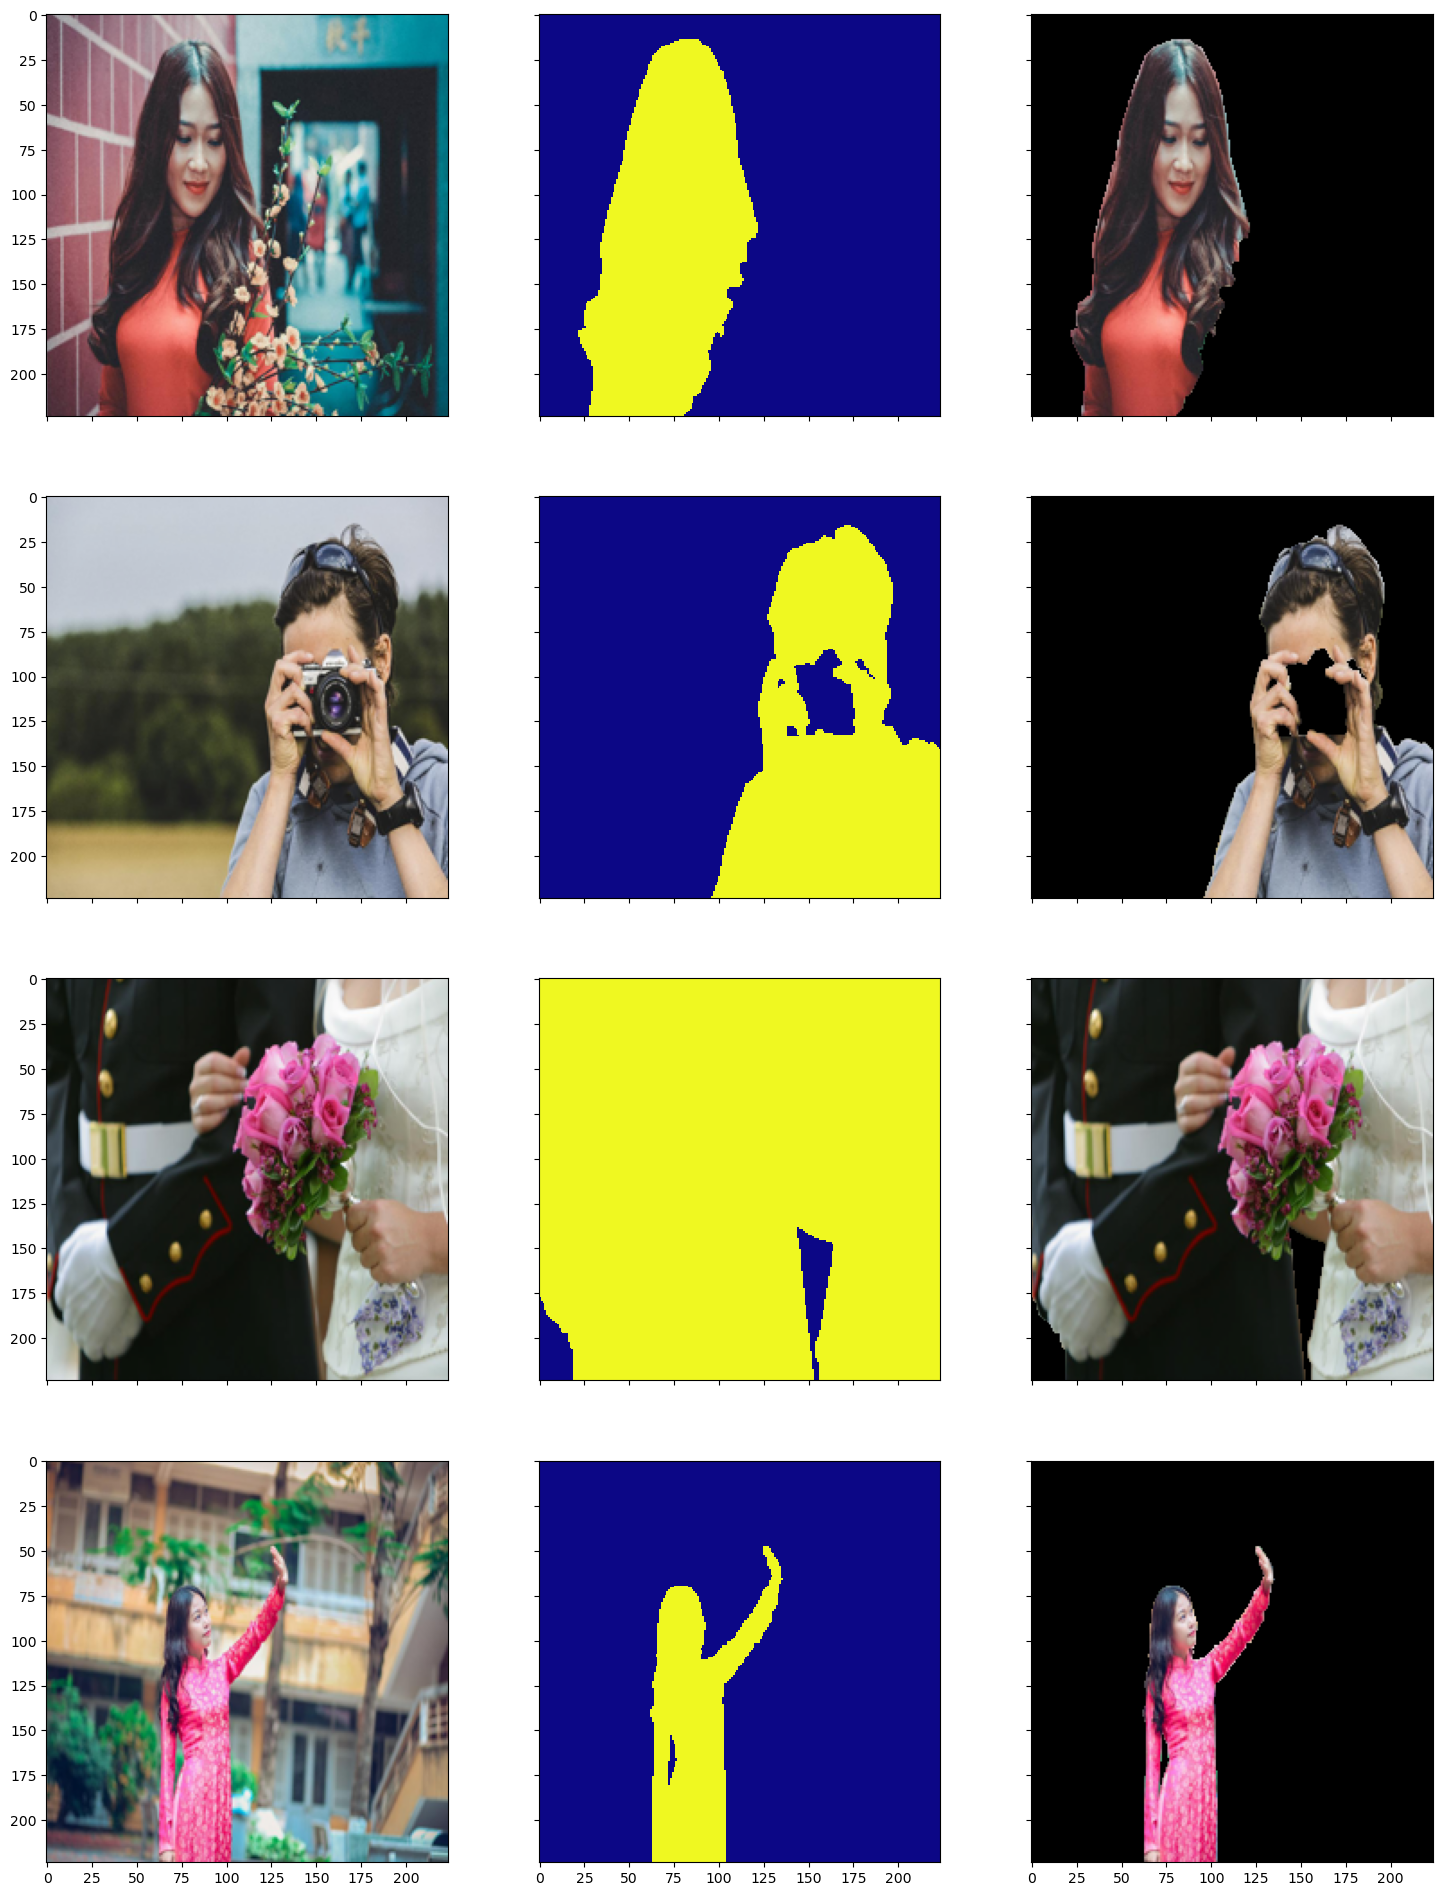

In [6]:
fig, ax = plt.subplots(nrows=4, ncols=3,figsize=(18, 24), sharey=True, sharex=True)

ax_flatten = ax.flatten()

for i in range(4):
    random_image = int(np.random.uniform(0,len(train_dataset)-1))
    image, mask = train_dataset[random_image]
    
    image = image.numpy().transpose((1, 2, 0))
    image = STD * image + MEAN
    image = np.clip(image, 0, 1)
    
    ax_flatten[3*i].imshow(image)
    ax_flatten[3*i+1].imshow(mask, cmap='plasma', interpolation='nearest')
    ax_flatten[3*i+2].imshow(torch.tensor(image, dtype=torch.float32) * mask.unsqueeze(2).float())

plt.show()

In [7]:
model = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet', in_channels=3, out_channels=1, init_features=32, pretrained=False)

Using cache found in C:\Users\user/.cache\torch\hub\mateuszbuda_brain-segmentation-pytorch_master


In [8]:
torch.cuda.empty_cache()
model.to(DEVICE)

batch_size = 32
num_epochs = 10
thresholds = 0.01, 0.1, 0.3, 0.5, 0.7
best_IoUs = [0.0] * len(thresholds)
lr = 0.001

criterion = nn.BCELoss()
optimizer = Adam(model.parameters(), lr=lr)  
scheduler = StepLR(optimizer, step_size=3, gamma=0.31)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
print(len(train_dataset), len(val_dataset))

5110 568


In [10]:
history = []

for epoch in range(num_epochs):
    
    y_true = None
    y_pred = None

    
    running_loss = 0.0
    
    model.train()
    for inputs, masks in tqdm(train_loader, desc="Train"):
        optimizer.zero_grad()
        
        inputs, masks = inputs.to(DEVICE), masks.to(DEVICE).unsqueeze(1).float()
        outputs = model(inputs)

        loss = criterion(outputs.float(), masks)
        running_loss += loss.item() * inputs.size(0)
        
        loss.backward()
        optimizer.step()
        
    train_loss = running_loss / len(train_loader.dataset)

    
    running_loss = 0.0
    
    model.eval()
    with torch.no_grad():
        for inputs, masks in tqdm(val_loader, desc="Val"):
            
            inputs, masks = inputs.to(DEVICE), masks.to(DEVICE).unsqueeze(1).float()
            outputs = model(inputs).float()
            
            y_true = masks.cpu() if y_true is None else torch.cat((y_true, masks.cpu()), dim=0)
            y_pred = outputs.cpu() if y_pred is None else torch.cat((y_pred, outputs.cpu()), dim=0)
                
            loss = criterion(outputs, masks)
            running_loss += loss.item() * inputs.size(0)
            
    val_loss = running_loss / len(val_loader.dataset)
             
    scheduler.step()

    
    IoUs = list(IoU((y_pred>threshold).int(), y_true) for threshold in thresholds)
    
    for i in range(len(thresholds)):
        if IoUs[i] > best_IoUs[i]:
            best_IoUs[i] = IoUs[i]
    model_path = Path(f'model_unet{epoch+1}.pth')
    if not model_path.exists():
        torch.save(model.state_dict(), model_path)
    
    history.append({
        'train_loss': train_loss,
        'val_loss': val_loss,
        **dict(zip(
            tuple(f'IoU_{x}' for x in thresholds),
            IoUs
        ))
    })

    print(
        f'Epoch [{epoch+1}/{num_epochs}], ',
        *(f'{key}: {history[-1][key]:.4f}' for key in history[-1])
    )


model_path = Path('model_unet10.pth')
if not model_path.exists():
    torch.save(model.state_dict(), model_path)

Train:   0%|          | 0/160 [00:00<?, ?it/s]

Val:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch [1/10],  train_loss: 0.3729 val_loss: 0.3414 IoU_0.01: 0.2645 IoU_0.1: 0.4487 IoU_0.3: 0.5459 IoU_0.5: 0.5687 IoU_0.7: 0.4998


Train:   0%|          | 0/160 [00:00<?, ?it/s]

Val:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch [2/10],  train_loss: 0.3118 val_loss: 0.3510 IoU_0.01: 0.3254 IoU_0.1: 0.5211 IoU_0.3: 0.5941 IoU_0.5: 0.5990 IoU_0.7: 0.5806


Train:   0%|          | 0/160 [00:00<?, ?it/s]

Val:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch [3/10],  train_loss: 0.2733 val_loss: 0.3229 IoU_0.01: 0.2805 IoU_0.1: 0.4927 IoU_0.3: 0.6090 IoU_0.5: 0.6381 IoU_0.7: 0.6270


Train:   0%|          | 0/160 [00:00<?, ?it/s]

Val:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch [4/10],  train_loss: 0.2322 val_loss: 0.2359 IoU_0.01: 0.3531 IoU_0.1: 0.5706 IoU_0.3: 0.6737 IoU_0.5: 0.6850 IoU_0.7: 0.6217


Train:   0%|          | 0/160 [00:00<?, ?it/s]

Val:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch [5/10],  train_loss: 0.2167 val_loss: 0.2219 IoU_0.01: 0.4433 IoU_0.1: 0.6386 IoU_0.3: 0.7005 IoU_0.5: 0.6928 IoU_0.7: 0.5999


Train:   0%|          | 0/160 [00:00<?, ?it/s]

Val:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch [6/10],  train_loss: 0.2019 val_loss: 0.2153 IoU_0.01: 0.3810 IoU_0.1: 0.6194 IoU_0.3: 0.6954 IoU_0.5: 0.7155 IoU_0.7: 0.6931


Train:   0%|          | 0/160 [00:00<?, ?it/s]

Val:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch [7/10],  train_loss: 0.1799 val_loss: 0.1958 IoU_0.01: 0.4526 IoU_0.1: 0.6679 IoU_0.3: 0.7378 IoU_0.5: 0.7271 IoU_0.7: 0.6652


Train:   0%|          | 0/160 [00:00<?, ?it/s]

Val:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch [8/10],  train_loss: 0.1717 val_loss: 0.1976 IoU_0.01: 0.4966 IoU_0.1: 0.6943 IoU_0.3: 0.7417 IoU_0.5: 0.7225 IoU_0.7: 0.6520


Train:   0%|          | 0/160 [00:00<?, ?it/s]

Val:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch [9/10],  train_loss: 0.1654 val_loss: 0.1913 IoU_0.01: 0.4959 IoU_0.1: 0.6784 IoU_0.3: 0.7406 IoU_0.5: 0.7393 IoU_0.7: 0.6903


Train:   0%|          | 0/160 [00:00<?, ?it/s]

Val:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch [10/10],  train_loss: 0.1573 val_loss: 0.1855 IoU_0.01: 0.4948 IoU_0.1: 0.6883 IoU_0.3: 0.7479 IoU_0.5: 0.7458 IoU_0.7: 0.7009


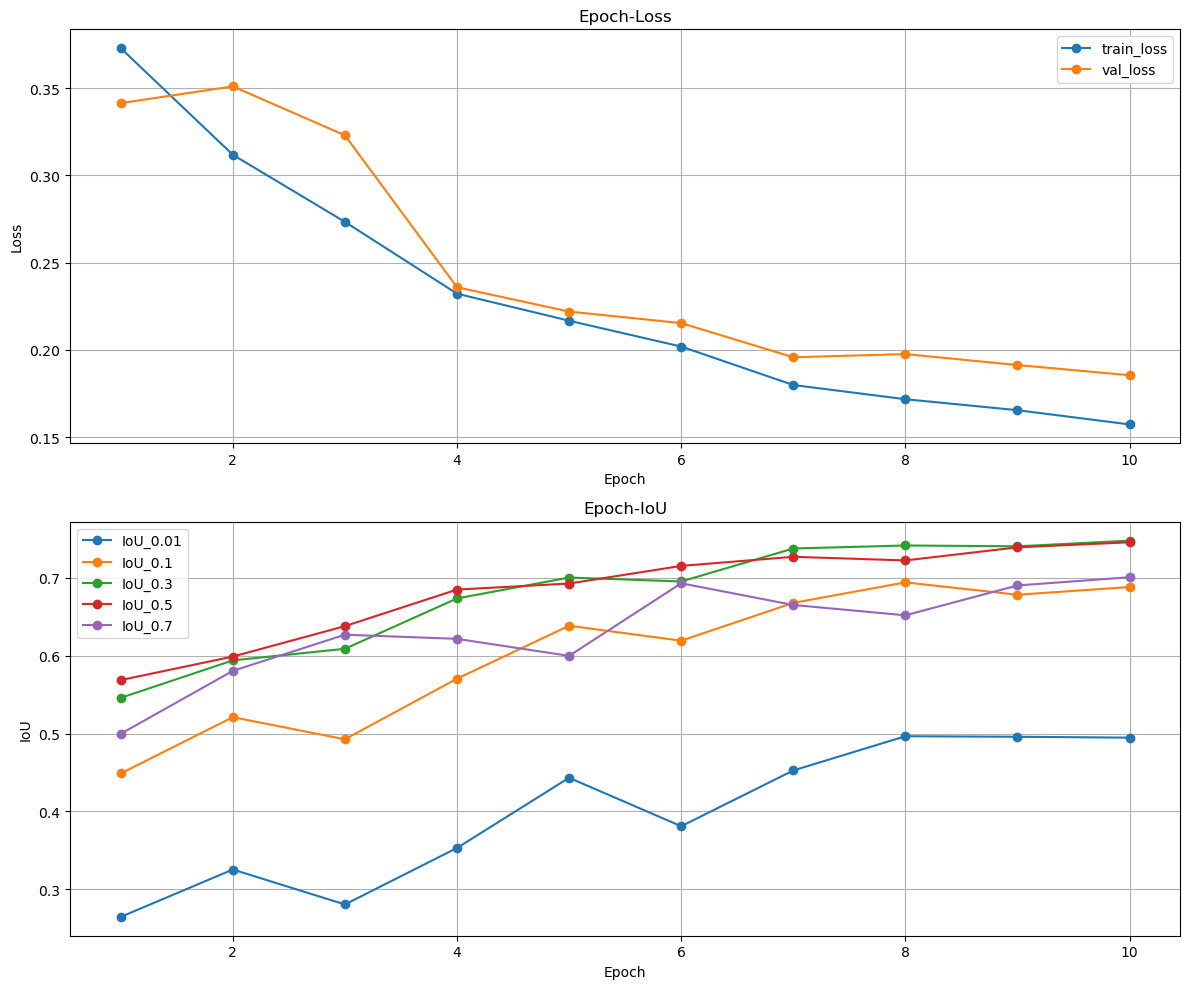

In [11]:
X = list(range(1, len(history)+1))

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12, 10))

ax[0].set_title('Epoch-Loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].grid(True)

ax[1].set_title('Epoch-IoU')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('IoU')
ax[1].grid(True)

for key in 'train_loss', 'val_loss':
    Y = [history[x - 1][key] for x in X]
    ax[0].plot(X, Y, marker='o', label=key)

for key in map(lambda x: f'IoU_{x}', thresholds):
    Y = [history[x - 1][key] for x in X]
    ax[1].plot(X, Y, marker='o', label=key)

ax[0].legend()
ax[1].legend()

plt.tight_layout()
plt.show()

In [12]:
model.load_state_dict(torch.load("model_unet10.pth")) 

<All keys matched successfully>

In [13]:
test_file_names = get_filenames(NAMES_PATH/'test.txt')
test_dataset = ImageDataset(ImageDataset.MODE.TEST, test_file_names, IMAGES_PATH)

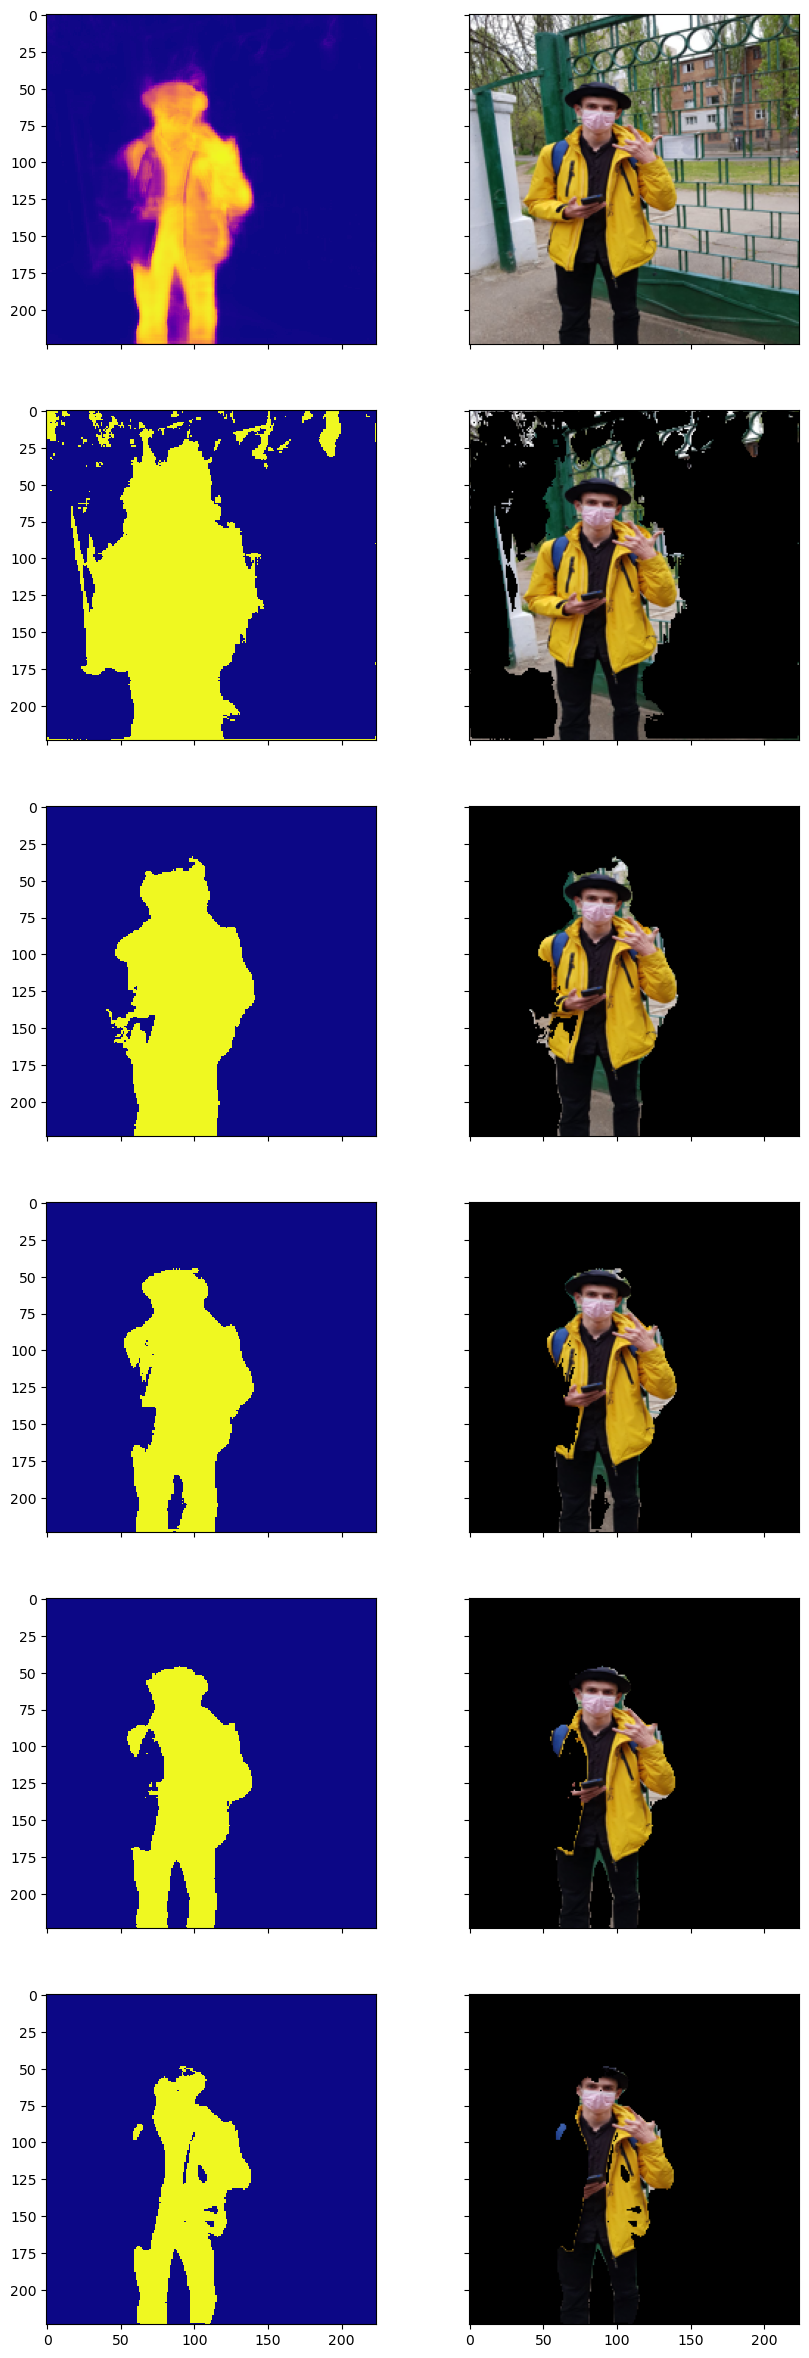

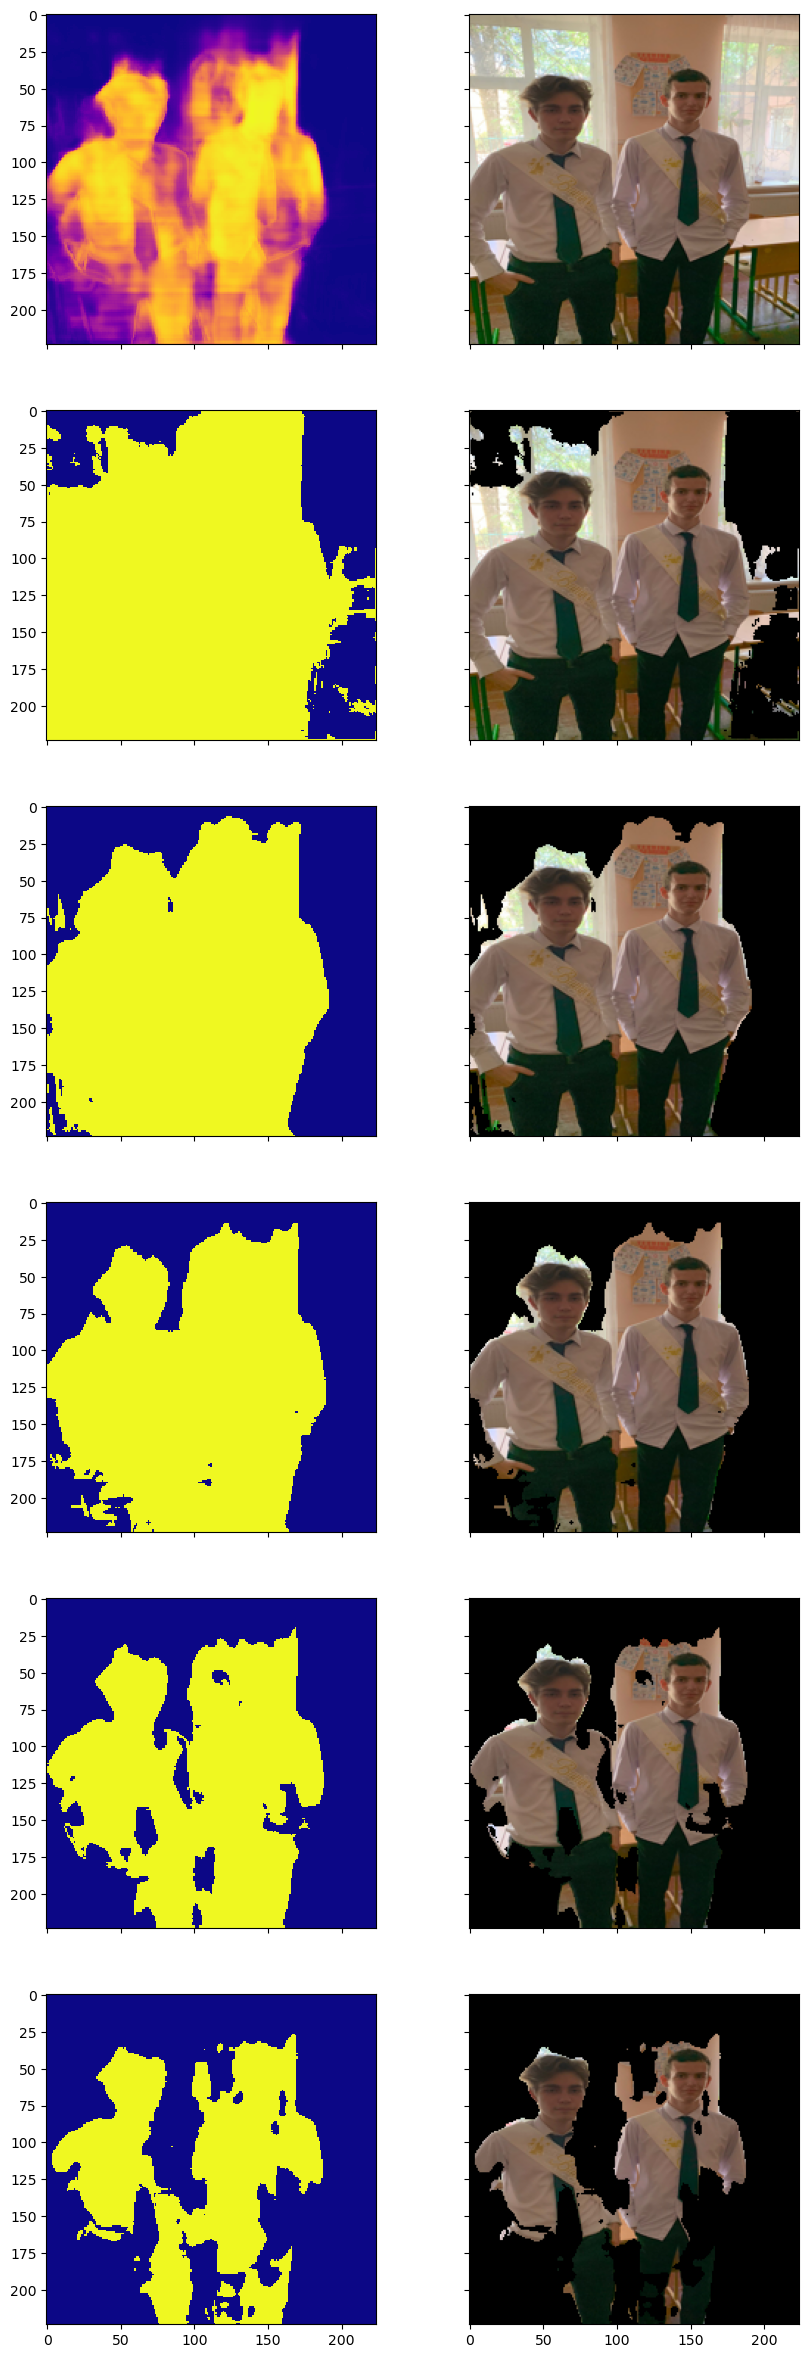

In [14]:
for test in test_dataset:
    test = test.unsqueeze(0).to(DEVICE)
    pred = torch.squeeze(model(test).cpu(), dim=(0, 1)).detach().numpy()
    
    test = test.squeeze(0).cpu().numpy().transpose((1, 2, 0))
    test = STD * test + MEAN
    test = np.clip(test, 0, 1)

    fig, ax = plt.subplots(nrows=6, ncols=2,figsize=(10, 30), sharey=True, sharex=True)
    
    ax_flatten = ax.flatten()
    ax_flatten[0].imshow(pred, cmap='plasma', interpolation='nearest')
    ax_flatten[1].imshow(test)
    
    for i, threshold in enumerate(thresholds):
        mask = (pred>threshold).astype(int)
        
        ax_flatten[2*(i+1)].imshow(mask, cmap='plasma', interpolation='nearest')
        ax_flatten[2*(i+1)+1].imshow(torch.tensor(test) * torch.tensor(mask).unsqueeze(2).float())